# SDCA & Pegasos on the Titanic dataset

# Implementation of the SDCA algorithm to estimate Support Vector Machines with a Lasso regularization, testing it on the Titanic dataset and compare it with a subgradient descent approach : the Pegasos one.

The aim of this project is to implement the SDCA algorithm to estimate Support Vector Machines with a Lasso regularization. We will also choose a database to test this algorithm, and we will end by compare its performances to a subgradient descent approach's performances.

We consider the following generic optimization problem associated with regularized loss minimization of linear predictors: let $x_{1},...,x_{n}$ be vectors in $\mathbb{R}^{d}$, $d \in \mathbb{N}^{*}$. Let also $\phi_{1},...,\phi_{n}$ be a sequence of scalar convex functions, and let $\lambda \in \mathbb{R}^{+*}$ be a regularization parameter. Our goal is to solve $\min_{w \in \mathbb{R}^{d}}{P(w)}$ with :

$$P(w)=\left[\frac{1}{n}\sum_{i=1}^{n}\phi_{i}\left(w^{T}x_{i}\right)+\lambda\left \| w \right \|\right]$$

Actually, we have data $x_{1},...,x_{n}$ (vectors in $\mathbb{R}^{d}$) and labels $y_{1},...,y_{n}$ in $\left[|-1;1|\right]$. A SVM is a linear discrimination of the following form : $D(x)=sign(w^{T}x+b)$, where $w \in \mathbb{R}^{p}$, and $b \in \mathbb{R}$ are given by the resolution of the problem $min_{w,b}\frac{1}{2}\left \| w \right \|^{2}$, with the condition $\forall i \in \left[|1;n|\right]$, $y_{i}\left(w^{T}x+b\right)\geq 1$.

Thus, given our specific SVM problem (with linear kernels and no bias term, and $a \in \mathbb{R}$), we set $\phi_{i}(a)=max(0,1-a\times y_{i})$.

Consequently, our goal is to solve $\min_{w \in \mathbb{R}^{d}}{P(w)}$ with :

$$P(w)=\left[\frac{1}{n}\sum_{i=1}^{n}\max\left(0,1-\left(w^{T}x_{i}\right)\times y_{i}\right)+\lambda\left \| w \right \|\right]$$

For the following programs, let's call $\theta$ the parameter we have to estimate and $X$ our data.

To help us in this resolution, we were inspired by this source :

http://www.jmlr.org/papers/volume14/shalev-shwartz13a/shalev-shwartz13a.pdf

It contains many results, especially the procedure SDCA-Perm($\alpha^{0}$). We will focus on this specific version of the SDCA algorithm because there is a result which gives us the form of $\Delta\alpha_{i}$ which increases dual.

Let's start by importing the necessary libraries for our program :

In [1]:
#import time is mostly important for the end of our study, when we will compare the different algorithms considering
#their respective runtimes. The library random will be useful for the step of random permutation creation of [|1;n|]

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
import time

Remember we are working with $\phi_{i}$ corresponding to the hinge loss. This loss is 1-Lipschitz, and we have $\phi_{i}^{*}(-a)=-ay_{i}$ with $-ay_{i} \in \left[0,1\right]$. The result of the course (source given above) tells us that for the hinge loss, the step (*) of the SDCA-Perm($\alpha^{0}$) algorithm has a closed form solution as :

$$\Delta\alpha_{i}=y_{i}\times max\left(0,min\left(1,\alpha_{i}^{(t-1)}y_{i}+\frac{1-x_{i}^{T}w^{(t-1)}y_{i}}{\frac{\left \| x_{i} \right \|^{2}}{\lambda n}}\right)\right)-\alpha_{i}^{(t-1)}$$

This will help us in the SDCA-Perm($\alpha^{0}$) algorithm.

# Test the algorithm on a database of our choice :

To train the SVM,  we have chosen a dataset taken from the Machine Learning competition entitled Titanic: Machine Learning from Disaster on Kaggle. The Titanic dataset can be accessed at this address: https://www.kaggle.com/c/titanic

During its sinking, more than 1,500 of the 2224 passengers were killed in part because of insufficient lifeboats. Here, the dataset consists of a list of 1309 passengers and the following information:

Survived: Passenger survived (0 = No, 1 = Yes)
Pclass: Travel class (1 = 1st, 2 = 2nd, 3 = 3rd)
Name: Name
Sex: Gender: Man
Age: 15 years old
Sibs: Number of siblings / wives on board
Parch: Number of parents / children on board
Fare: Price for the passenger
Cabin: Cabin
Embarked: Port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)

So the objective is to train our SVM classifier on this dataset to be able to predict with what probability a passenger can survive (label = 1) or die (label = 0), regarding its characteristics.

Note: we only focus on the train dataset for our study.

**Loading the data :**

In [3]:
import pandas as pd

data = pd.read_csv("../Dataset Titanic/train.csv",sep=',',index_col=0)

data = data.dropna()
X=data[['Pclass','Sex','Age','SibSp','Parch','Fare']]
X = pd.get_dummies(X)
b=data.Survived

X = X.values
b = b.values

nombre_dechantillons = X.shape[0]
nombre_de_covariables = X.shape[1]

In [4]:
import sklearn.preprocessing

X = sklearn.preprocessing.normalize(X)

Choosing the parameters :

In [5]:
lambdaa = 1./nombre_de_covariables    #facteur de pénalisation Lasso
etha = 1./(np.linalg.norm(X))        #pas de descente
T = 183     #nombre d'itérations

# Implementation of SDCA-Perm($α^{0}$) algorithm

In [6]:
def P(theta,lambdaa):
    hinge_loss = 1-np.multiply(b,X.dot(theta))
    hinge_loss[hinge_loss <= 0] = 0
    return np.mean(hinge_loss) + lambdaa*np.linalg.norm(theta, ord=1)

In [7]:
def SDCA_Perm(T, lambdaa, etha):
    
#Déclenchement du chronomètre (utile pour comparer les performances des algorithmes en termes de rapidité de calcul)
    origine_des_temps = time.time()
    
#On initialise la procédure SDCA-Perm(α0)
    alpha = np.zeros(nombre_dechantillons)
    alpha_stock = np.zeros((nombre_dechantillons,nombre_dechantillons))
    w = (1./(lambdaa*nombre_dechantillons))*np.dot(X.T,alpha)
    w_stock = [0]*nombre_dechantillons
    t = 0
    
#Calcul du coût à chaque étape
    hinge_loss_cost = np.empty(shape=[T])
    execution_time = np.empty(shape=[T,2])
    
    for epoch in range(0,T):
        hinge_loss_cost[epoch] = P(w,lambdaa)
        execution_time[epoch] = (time.time()-origine_des_temps, P(w,lambdaa))
        
        #Création d'une permutation aléatoire de l'ensemble {}
        t += 1
        i=np.random.randint(0, nombre_dechantillons)
            
#Utilisation de la fonction clip qui englobe le traitement du min et du max dans la définition de Delta_alpha_i  

        m=(X[i].T.dot(w))*b[i]
        p=(np.linalg.norm(X[i])**2)/(lambdaa*nombre_dechantillons)
            
            
        delta_alpha_i = b[i]*np.clip((alpha[i]*b[i]+((1-m)/p)), a_min = 0, a_max = 1)-alpha[i]
            
        alpha[i] = alpha[i] + delta_alpha_i
        w = w + (delta_alpha_i*X[i])/(lambdaa*nombre_dechantillons)
            
        alpha_stock[:,t-1] = alpha[i]

        w_stock[t-1] = w
    
    #Output : random option
    
    t_tilde = np.random.randint((T/2)+1,T+1)           #d'après la théorie, T/2 est un bon choix pour T0
    
    w_bar = w_stock[t_tilde-1]
    alpha_bar = alpha_stock[:,(t_tilde-1)]
    
    return w_bar, hinge_loss_cost, execution_time

In [8]:
theta, hinge_cost_SDCA, exec_time_SDCA = SDCA_Perm(T=T,lambdaa=lambdaa,etha=etha)

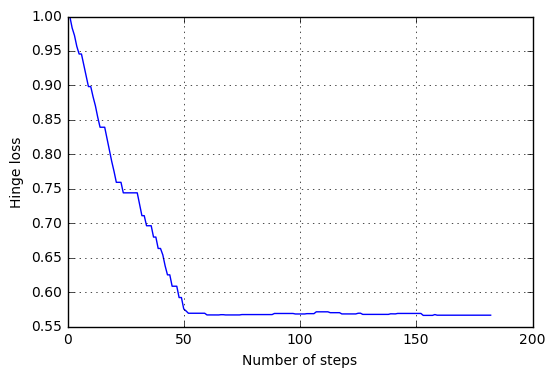

In [9]:
plt.plot(hinge_cost_SDCA, lw = 1)
plt.grid()
plt.ylabel('Hinge loss')
plt.xlabel('Number of steps')
plt.show()

# Implementation of a subgradient descent approach : the Pegasos algorithm

The Pegasos algorithm is an application of a stochastic subgradient method. It has been claimed and experimentally observed that stochastic algorithms yield the best generalization performance despite being the worst optimization algorithms. We would like to thank The University of Chicago for the detailed course about this subject : http://ttic.uchicago.edu/~nati/Publications/PegasosMPB.pdf 

Here, we will present you the basic version of the Pegasos algorithm. On each iteration Pegasos operates as follow. Initially, we set $w_{1}$ to the zero vector. On iteration $t$ of the algorithm, we first choose a random training example $\left(x_{i_{t}},y_{i_{t}}\right)$ by picking an index $i_{t} \in [|1;m|]$ uniformly at random. Then, we replace the objective in the equation we aim to solve with an approximation based on this training example, yielding (with $l$ our loss function, still the hinge loss):

$$f(w;i_{t}) = \lambda \left \| w \right \| +  l\left(w;\left(x_{i_{t}},y_{i_{t}}\right)\right)$$

We consider the subgradient on the above approximate objective, given by:

$$\nabla_{t}=\lambda w_{t} - \mathbb{1}[y_{i_{t}}\langle w_{t},x_{i_{t}}\rangle <1]y_{i_{t}}x_{i_{t}}$$

Then, we update $w_{t+1} \leftarrow w_{t} - \eta_{t}\nabla_{t}$ using a step size of $\eta_{t}=\frac{1}{t\lambda}$. After a predetermined number of iterations $T$, we output the last iterate $w_{T+1}$. The code is the following:

**Implementation of Pegasos algorithm :**

In [10]:
from math import sqrt

In [11]:
def Pegasos(T, lambdaa, etha):
    
#Déclenchement du chronomètre (utile pour comparer les performances des algorithmes en termes de rapidité de calcul)
    origine_des_temps = time.time()
    
#On initialise la procédure Pegasos
    w=np.zeros(nombre_de_covariables)
    
#Calcul du coût à chaque étape
    hinge_loss_cost = np.empty(shape=[T])
    execution_time = np.empty(shape=[T,2])
    
    for epoch in range(0,T):
        hinge_loss_cost[epoch] = P(w,lambdaa)
        execution_time[epoch] = (time.time()-origine_des_temps, P(w,lambdaa))
        
        #Création d'une permutation aléatoire de l'ensemble {}
        i=np.random.randint(1, nombre_dechantillons)
        etha = 1./(lambdaa*(epoch+1))
        
        if b[i]*np.vdot(w,X[i]) < 1:
            w = (1-etha*lambdaa)*w + etha*b[i]*X[i]
        else:
            w = (1-etha*lambdaa)*w

        #Optionnel                
        w = min(1,(1./(sqrt(lambdaa)*np.linalg.norm(w,ord=1))))*w

    return w, hinge_loss_cost, execution_time

In [12]:
theta, hinge_cost_Pegasos, exec_time_Pegasos = Pegasos(T=T,lambdaa=lambdaa,etha=etha)

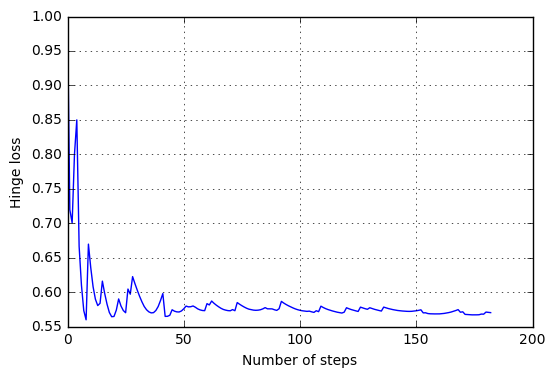

In [13]:
plt.plot(hinge_cost_Pegasos, lw = 1)
plt.grid()
plt.ylabel('Hinge loss')
plt.xlabel('Number of steps')
plt.show()

# Algorithmic comparison phase:

***NB: when we say A "take the precedence over" B, we refer to the moment when A definitely exceeds B in terms of performance (lower values for the loss function).***

Now, let's focus on the comparison of our two algorithms, in terms of loss function, but also in terms of the number of iterations needed for convergence. Indeed, this measurement is more accurate because it is an absolute measure that has a link only with the algorithms, in contradiction with the computation time which is also a function of the characteristics and performances of the machine on which the algorithms turn. Let's see:

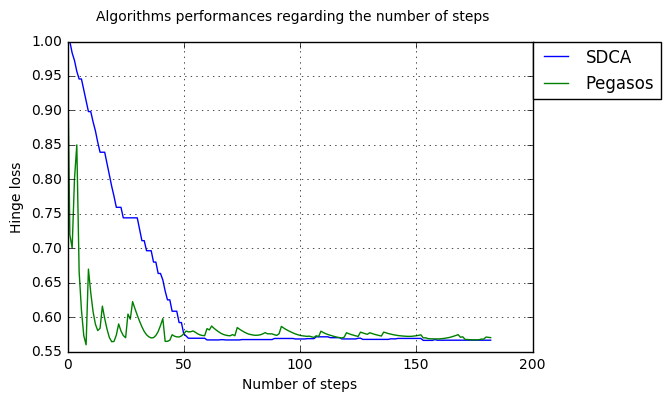

In [16]:
plt.plot(hinge_cost_SDCA, lw=1, label='SDCA')
plt.plot(hinge_cost_Pegasos, lw=1, label='Pegasos')

plt.grid()
plt.ylabel('Hinge loss')
plt.xlabel('Number of steps')
plt.legend(bbox_to_anchor=(1,1), loc=2, borderaxespad=0.)
plt.suptitle('Algorithms performances regarding the number of steps')
plt.show()

Initially, the loss function of SDCA takes values greater than the loss function of Pegasos. The SDCA loss takes longer to converge than Pegasos loss (the SDCA loss needs 50 steps before almost stopping its decay): Pegasos loss begins with strong oscillation, then it takes between 5 and 10 steps to clearly reduce its value. We have to wait between 10 and 20 steps to see it starting to "stabilize" (a stabilization however very relative for Pegasos which will continue to oscillate over the steps). Over the steps, it will reduce the amplitude of its oscillations.

However, after 50 steps, the SDCA loss shows the best performances (lower values) than the Pegasos loss (although both remain very close, especially after 150 steps).

Unlike the fictitious dataset, here, it is SDCA which shows the best performances after a certain number of steps, which could allow us to speculate that SDCA is "better" than Pegasos with a less extensive dataset (183 individuals and 7 variables).

The decays do not remain perfect insofar as they are not perfectly strict (it happens to the functions of loss to grow episodically between two steps).

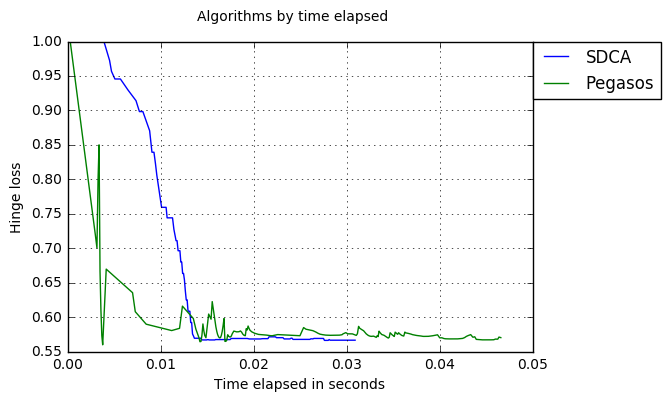

In [17]:
plt.plot(exec_time_SDCA[:,0], exec_time_SDCA[:,1], lw=1, label='SDCA')
plt.plot(exec_time_Pegasos[:,0], exec_time_Pegasos[:,1], lw=1, label='Pegasos')


plt.grid()
plt.ylabel('Hinge loss')
plt.xlabel('Time elapsed in seconds')
plt.legend(bbox_to_anchor=(1,1), loc=2, borderaxespad=0.)
plt.suptitle('Algorithms by time elapsed')
plt.show()

SDCA requires an execution time of about 13 thousandth of seconds to converge. For its part, Pegasos oscillates very strongly the first 5 thousandths of a second. Then, it continues to oscillate over time (even if the amplitudes of oscillation decrease more and more), and it requires an execution time of about 17 thousandths of a second to stabilize; which is the time needed for SDCA to take precedence over Pegasos.

# Clarifications:

**However, we would like to provide some clarifications. Empirically, and compared to traditional FISTA, SVRG and SAGA algorithms, the SDCA algorithm seems to be very efficient when the number of features is very large compared to the number of individuals because it does not optimize on the set the features, but on the set of individuals. Here, by "performance" we mean: better performance for the hinge loss, as much in terms of the number of steps as the execution time.**

**In our case, it is the opposite: we have few features and many individuals. Moreover, here we compare SDCA to Pegasos (and not to FISTA, SVRG and SAGA), and against Pegasos, SDCA does not perform better when there are few individuals and many features (we have tested this on the fictitious data by putting few individuals and many features).**

# BONUS - Implementation of the Kernelized Pegasos algorithm:

Unfortunately, we failed to implement this algorithm and run it in our data. It presents some specificities that make it complicated to implement. It is essential to understand well some theoretical background beforehand, especially on non-linear kernels before trying any implementation. We wanted to do it, but it was not possible due to lack of time. Anyway, here is our attempt of implementation:

In [19]:
def Pegasos_Kernel2(T, lambdaa): #cette fois, pas besoin de mettre etha en paramètre car il est définit plus bas
    
#Déclenchement du chronomètre (utile pour comparer les performances des algorithmes en termes de rapidité de calcul)
    origine_des_temps = time.time()
    
#On initialise la procédure Pegasos
    alpha=np.zeros(nombre_dechantillons)
    
#Calcul du coût à chaque étape
    hinge_loss_cost = np.empty(shape=[T])
    execution_time = np.empty(shape=[T,2])
    
    w=np.zeros(nombre_de_covariables)
    for epoch in range(0,T): 
        hinge_loss_cost[epoch] = P(w,lambdaa)
        execution_time[epoch] = (time.time()-origine_des_temps, P(w,lambdaa))
        
        etha = 1./(lambdaa*(epoch+1))
        
        #random selection of a couple(x,y)
        i = np.random.randint(0, nombre_dechantillons)
        myrange = list(range(0,nombre_dechantillons))
        Somme_k=0
        for k in myrange:
            Somme_k += alpha[k]*b[k]*np.dot(X[i],X[k].T) #pour kernel lineaire
        Somme_k = b[i]*etha*Somme_k
        if Somme_k < 1:
            alpha[i]=alpha[i]+1
        else:
            alpha[i]=alpha[i]
        for k in myrange:
            w+=etha*alpha[k]*b[k]*X[k]
    return w, hinge_loss_cost, execution_time